### Preliminaries

In [1]:
# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream, fit2, params

### Get the molecular and perceptual data

In [3]:
training_CIDs = loading.get_CIDs('training')
leaderboard_CIDs = loading.get_CIDs('leaderboard')
tl_CIDs = loading.get_CIDs(['training','leaderboard'])
testset_CIDs = loading.get_CIDs('testset')
all_CIDs = loading.get_CIDs(['training','leaderboard','testset'])

print("We initially had perceptual data for %d unique molecules" % len(training_CIDs))
print("An additional %d were used for the initial leaderboard, but made available before the submission deadline, giving us perceptual data for %d." \
      % (len(leaderboard_CIDs),len(tl_CIDs)))
print("A separate %d distinct from those %d of those were used for evaluating the final submitted models." % (len(testset_CIDs),len(tl_CIDs)))

We initially had perceptual data for 338 unique molecules
An additional 69 were used for the initial leaderboard, but made available before the submission deadline, giving us perceptual data for 407.
A separate 69 distinct from those 407 of those were used for evaluating the final submitted models.


In [4]:
molecular_data = loading.get_molecular_data(['dragon'],all_CIDs)
molecular_data.head()

Dragon has 4869 features for 476 molecules.
There are now 4869 total features.


dragon                                                 \
    complexity from pubmed      MW    AMW      Sv      Se      Sp      Si   
CID                                                                         
126                   93.1  122.13  8.142  10.010  15.305  10.193  16.664   
176                   31.0   60.06  7.508   4.483   8.422   4.432   9.249   
177                   10.3   44.06  6.294   3.768   7.095   3.977   8.040   
180                   26.3   58.09  5.809   5.295   9.978   5.739  11.455   
196                  114.0  146.16  7.308  11.493  20.727  11.625  22.914   

                             ...                                              \
        Mv     Me     Mp     ...      Psychotic-80 Psychotic-50 Hypertens-80   
CID                          ...                                               
126  0.667  1.020  0.680     ...                 0            0            0   
176  0.560  1.053  0.554     ...                 0            0            0   
177  0.538  1.014  0.568     ...                 0            0            0   
180  0.530  0.998  0.574     ...                 0            0            0   
196  0.575  1.036  0.581     ...                 0            0            0   

                                                                      \
    Hypertens-50 Hypnotic-80 Hypnotic-50 Neoplastic-80 Neoplastic-50   
CID                                                                    
126            0           0           0             0             0   
176            0           0           0             0             0   
177            0           0           0             0             0   
180            0           0           0             0             0   
196            0           0           0             0             0   

                               
    Infective-80 Infective-50  
CID                            
126            0            0  
176            0            0  
177            0            0  
180            0            0  
196            0            0  

[5 rows x 4869 columns]

In [5]:
# Load the perceptual descriptors data.  
perceptual_data = loading.load_perceptual_data(['training','leaderboard'])
perceptual_data.head()

Metadata         Subject  \
                                                    Name Solvent       1   
Descriptor CID Dilution Replicate                                          
Intensity  126 -3.0     0          4-Hydroxybenzaldehyde    None     7.0   
               -1.0     0          4-Hydroxybenzaldehyde    None    37.0   
           176 -7.0     0                    acetic acid    None     0.0   
               -5.0     0                    acetic acid    None     0.0   
           177 -5.0     0                   acetaldehyde    None     3.0   

                                                                             \
                                      2     3      4     5    6     7     8   
Descriptor CID Dilution Replicate                                             
Intensity  126 -3.0     0          55.0  89.0   29.0   0.0  0.0   6.0  46.0   
               -1.0     0          64.0   0.0  100.0  58.0  0.0  18.0  51.0   
           176 -7.0     0           0.0   0.0   20.0   0.0  0.0   0.0   0.0   
               -5.0     0          83.0  69.0    0.0  67.0  0.0   0.0  57.0   
           177 -5.0     0          60.0   0.0   10.0   0.0  0.0  83.0   0.0   

                                   ...                                      \
                                   ...     40    41   42    43    44    45   
Descriptor CID Dilution Replicate  ...                                       
Intensity  126 -3.0     0          ...    0.0   0.0  2.0  28.0  33.0  64.0   
               -1.0     0          ...   76.0  49.0  0.0  78.0  21.0  50.0   
           176 -7.0     0          ...    0.0   0.0  1.0   0.0  24.0  52.0   
               -5.0     0          ...    0.0   0.0  0.0   0.0   3.0   0.0   
           177 -5.0     0          ...   28.0   0.0  0.0  27.0  29.0  37.0   

                                                           
                                     46    47    48    49  
Descriptor CID Dilution Replicate                          
Intensity  126 -3.0     0           0.0   0.0   0.0  18.0  
               -1.0     0          50.0  85.0   9.0   7.0  
           176 -7.0     0           0.0   0.0   0.0   0.0  
               -5.0     0           0.0   0.0  14.0   0.0  
           177 -5.0     0          55.0   6.0   0.0   0.0  

[5 rows x 51 columns]

In [6]:
descriptors = loading.get_descriptors(format=True)
n_descriptors = len(descriptors)
assert n_descriptors == opc_python.NUM_DESCRIPTORS
n_subjects = perceptual_data['Subject'].shape[1]
assert n_subjects == opc_python.NUM_SUBJECTS
print('There are %d different perceptual descriptors and %d different subjects' % (n_descriptors,n_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [7]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % int(perceptual_data.shape[0]/21))
print("%d of these are replicates (same subject and molecule, two different dilutions)" % int(sum(list(zip(*perceptual_data.index.values.tolist()))[3])/21))

There are 785 rows in the perceptual data set (at least one for each subject and molecule)
40 of these are replicates (same subject and molecule, two different dilutions)


### Format the perceptual data

In [8]:
Y_tl = dream.make_Y(perceptual_data)
# We must also have an imputed version that we can use as input to the algorithm since it will not work with NaNs.  
Y_tl_imputed = dream.make_Y(perceptual_data, imputer='median')
#Y_tl_gold = dream.make_Y(perceptual_data, concentration='gold')
Y_tl.head()

1                                                          \
Descriptor   Acid Ammonia Bakery Burnt Chemical Cold Decayed Fish Flower   
CID Dilution                                                               
126 -3.0      0.0     0.0    0.0   0.0      0.0  0.0     0.0  0.0    0.0   
    -1.0      0.0     0.0    0.0   0.0      0.0  0.0     0.0  0.0    0.0   
176 -7.0      0.0     0.0    0.0   0.0      0.0  0.0     0.0  0.0    0.0   
    -5.0      0.0     0.0    0.0   0.0     12.0  0.0     0.0  0.0    0.0   
177 -5.0      0.0     0.0    0.0   0.0      0.0  0.0     0.0  0.0    0.0   

                   ...     49                                                  \
Descriptor   Fruit ...  Grass Intensity Musky Pleasantness Sour Spices Sweaty   
CID Dilution       ...                                                          
126 -3.0       0.0 ...    0.0      18.0   0.0         65.0  0.0    5.0    0.0   
    -1.0       0.0 ...    0.0       7.0   0.0         43.0  0.0    0.0    0.0   
176 -7.0       0.0 ...    NaN       0.0   NaN          NaN  NaN    NaN    NaN   
    -5.0       0.0 ...    4.0       0.0   0.0         56.0  0.0    0.0    0.0   
177 -5.0       0.0 ...    0.0       0.0   0.0         66.0  0.0    3.0    0.0   

                              
Descriptor   Sweet Warm Wood  
CID Dilution                  
126 -3.0       0.0  0.0  0.0  
    -1.0       0.0  0.0  0.0  
176 -7.0       NaN  NaN  NaN  
    -5.0       0.0  0.0  0.0  
177 -5.0       5.0  2.0  3.0  

[5 rows x 1029 columns]

In [9]:
perceptual_data.loc['Intensity'].loc[243]

Metadata         Subject                                  \
                       Name Solvent       1    2    3    4     5    6     7   
Dilution Replicate                                                            
-5.0     0              N/A    None    73.0  0.0  0.0  2.0  61.0  0.0  25.0   

                         ...                                                   \
                       8 ...    40   41   42   43    44   45    46   47    48   
Dilution Replicate       ...                                                    
-5.0     0          43.0 ...   0.0  0.0  0.0  0.0  23.0  0.0  38.0  0.0  71.0   

                         
                     49  
Dilution Replicate       
-5.0     0          0.0  

[1 rows x 51 columns]

In [10]:
# Create the subsets used for initial training and for the leaderboard.  
Y_training_imputed = Y_tl_imputed.loc[training_CIDs]
Y_training = Y_tl.loc[training_CIDs]
Y_leaderboard = Y_tl.loc[leaderboard_CIDs]

### Load and formatting the molecular data

In [11]:
all_CID_dilutions = loading.get_CID_dilutions(['training','leaderboard','testset'])
X_all = dream.make_X(molecular_data,all_CID_dilutions)[0]

The X matrix now has shape (952x3084) molecules by non-NaN good molecular descriptors


In [12]:
training_CID_dilutions = loading.get_CID_dilutions('training')
X_training = X_all.loc[training_CID_dilutions]
X_training.head()

(dragon, complexity from pubmed)  (dragon, MW)  (dragon, AMW)  \
CID Dilution                                                                  
126 -3.0                             -0.131027     -0.456652       0.690508   
    -1.0                             -0.131027     -0.456652       0.690508   
176 -7.0                             -1.406151     -2.241719       0.437257   
    -5.0                             -1.406151     -2.241719       0.437257   
177 -5.0                             -2.291391     -2.897876      -0.090647   

              (dragon, Sv)  (dragon, Se)  (dragon, Sp)  (dragon, Si)  \
CID Dilution                                                           
126 -3.0         -0.644287     -0.945447     -0.802655     -1.025999   
    -1.0         -0.644287     -0.945447     -0.802655     -1.025999   
176 -7.0         -2.435882     -2.224322     -2.600611     -2.238898   
    -5.0         -2.435882     -2.224322     -2.600611     -2.238898   
177 -5.0         -2.764227     -2.546772     -2.799880     -2.494103   

              (dragon, Mv)  (dragon, Me)  (dragon, Mp)      ...        \
CID Dilution                                                ...         
126 -3.0          1.389536      1.210578      0.637563      ...         
    -1.0          1.389536      1.210578      0.637563      ...         
176 -7.0         -0.183611      2.776472     -0.793801      ...         
    -5.0         -0.183611      2.776472     -0.793801      ...         
177 -5.0         -0.531459      0.922255     -0.624669      ...         

              (dragon, Hypertens-80)  (dragon, Hypertens-50)  \
CID Dilution                                                   
126 -3.0                   -0.263799               -0.064923   
    -1.0                   -0.263799               -0.064923   
176 -7.0                   -0.263799               -0.064923   
    -5.0                   -0.263799               -0.064923   
177 -5.0                   -0.263799               -0.064923   

              (dragon, Hypnotic-80)  (dragon, Hypnotic-50)  \
CID Dilution                                                 
126 -3.0                  -0.528466              -0.130675   
    -1.0                  -0.528466              -0.130675   
176 -7.0                  -0.528466              -0.130675   
    -5.0                  -0.528466              -0.130675   
177 -5.0                  -0.528466              -0.130675   

              (dragon, Neoplastic-80)  (dragon, Neoplastic-50)  \
CID Dilution                                                     
126 -3.0                    -0.435661                -0.102978   
    -1.0                    -0.435661                -0.102978   
176 -7.0                    -0.435661                -0.102978   
    -5.0                    -0.435661                -0.102978   
177 -5.0                    -0.435661                -0.102978   

              (dragon, Infective-80)  (dragon, Infective-50)  dilution  \
CID Dilution                                                             
126 -3.0                   -0.734769               -0.122105      -3.0   
    -1.0                   -0.734769               -0.122105      -1.0   
176 -7.0                   -0.734769               -0.122105      -7.0   
    -5.0                   -0.734769               -0.122105      -5.0   
177 -5.0                   -0.734769               -0.122105      -5.0   

              mean_dilution  
CID Dilution                 
126 -3.0                0.0  
    -1.0                1.0  
176 -7.0                2.0  
    -5.0                3.0  
177 -5.0                4.0  

[5 rows x 3084 columns]

In [13]:
leaderboard_CID_dilutions = loading.get_CID_dilutions('leaderboard')
X_leaderboard = X_all.loc[leaderboard_CID_dilutions]
X_leaderboard.head()

(dragon, complexity from pubmed)  (dragon, MW)  (dragon, AMW)  \
CID Dilution                                                                  
243 -5.0                              0.025182     -0.456652       0.690508   
    -3.0                              0.025182     -0.456652       0.690508   
454 -5.0                             -0.705040     -0.317648      -0.665097   
    -3.0                             -0.705040     -0.317648      -0.665097   
679 -3.0                             -1.469467     -1.628249       0.561598   

              (dragon, Sv)  (dragon, Se)  (dragon, Sp)  (dragon, Si)  \
CID Dilution                                                           
243 -5.0         -0.644287     -0.945447     -0.802655     -1.025999   
    -3.0         -0.644287     -0.945447     -0.802655     -1.025999   
454 -5.0          0.034788      0.245590      0.130763      0.310286   
    -3.0          0.034788      0.245590      0.130763      0.310286   
679 -3.0         -2.031168     -1.871083     -1.873100     -1.839485   

              (dragon, Mv)  (dragon, Me)  (dragon, Mp)      ...        \
CID Dilution                                                ...         
243 -5.0          1.389536      1.210578      0.637563      ...         
    -3.0          1.389536      1.210578      0.637563      ...         
454 -5.0         -0.872456     -0.930729     -0.458293      ...         
    -3.0         -0.872456     -0.930729     -0.458293      ...         
679 -3.0         -0.372193      0.487631      0.192816      ...         

              (dragon, Hypertens-80)  (dragon, Hypertens-50)  \
CID Dilution                                                   
243 -5.0                   -0.263799               -0.064923   
    -3.0                   -0.263799               -0.064923   
454 -5.0                   -0.263799               -0.064923   
    -3.0                   -0.263799               -0.064923   
679 -3.0                   -0.263799               -0.064923   

              (dragon, Hypnotic-80)  (dragon, Hypnotic-50)  \
CID Dilution                                                 
243 -5.0                  -0.528466              -0.130675   
    -3.0                  -0.528466              -0.130675   
454 -5.0                  -0.528466              -0.130675   
    -3.0                  -0.528466              -0.130675   
679 -3.0                  -0.528466              -0.130675   

              (dragon, Neoplastic-80)  (dragon, Neoplastic-50)  \
CID Dilution                                                     
243 -5.0                    -0.435661                -0.102978   
    -3.0                    -0.435661                -0.102978   
454 -5.0                    -0.435661                -0.102978   
    -3.0                    -0.435661                -0.102978   
679 -3.0                    -0.435661                -0.102978   

              (dragon, Infective-80)  (dragon, Infective-50)  dilution  \
CID Dilution                                                             
243 -5.0                   -0.734769               -0.122105      -5.0   
    -3.0                   -0.734769               -0.122105      -3.0   
454 -5.0                   -0.734769               -0.122105      -5.0   
    -3.0                   -0.734769               -0.122105      -3.0   
679 -3.0                   -0.734769               -0.122105      -3.0   

              mean_dilution  
CID Dilution                 
243 -5.0               16.0  
    -3.0               17.0  
454 -5.0               40.0  
    -3.0               41.0  
679 -3.0               48.0  

[5 rows x 3084 columns]

In [14]:
tl_CID_dilutions = loading.get_CID_dilutions(['training','leaderboard'])
X_tl = X_all.loc[tl_CID_dilutions]

In [15]:
testset_CID_dilutions = loading.get_CID_dilutions('testset')
X_testset = X_all.loc[testset_CID_dilutions]
X_testset.head()

(dragon, complexity from pubmed)  (dragon, MW)  (dragon, AMW)  \
CID Dilution                                                                  
180 -3.0                             -1.559740     -2.315655      -0.320587   
    -1.0                             -1.559740     -2.315655      -0.320587   
262 -5.0                             -1.421719     -1.272468      -0.406694   
    -3.0                             -1.421719     -1.272468      -0.406694   
264 -5.0                             -0.919964     -1.330099      -0.090647   

              (dragon, Sv)  (dragon, Se)  (dragon, Sp)  (dragon, Si)  \
CID Dilution                                                           
180 -3.0         -2.102940     -1.886842     -2.095107     -1.825468   
    -1.0         -2.102940     -1.886842     -2.095107     -1.825468   
262 -5.0         -1.174519     -0.828891     -1.179748     -0.785305   
    -3.0         -1.174519     -0.828891     -1.179748     -0.785305   
264 -5.0         -1.332604     -1.121982     -1.390902     -1.106462   

              (dragon, Mv)  (dragon, Me)  (dragon, Mp)      ...        \
CID Dilution                                                ...         
180 -3.0         -0.660298      0.147792     -0.553034      ...         
    -1.0         -0.660298      0.147792     -0.553034      ...         
262 -5.0         -1.088201      0.487631     -0.904039      ...         
    -3.0         -1.088201      0.487631     -0.904039      ...         
264 -5.0         -0.531459      0.922255     -0.624669      ...         

              (dragon, Hypertens-80)  (dragon, Hypertens-50)  \
CID Dilution                                                   
180 -3.0                   -0.263799               -0.064923   
    -1.0                   -0.263799               -0.064923   
262 -5.0                   -0.263799               -0.064923   
    -3.0                   -0.263799               -0.064923   
264 -5.0                   -0.263799               -0.064923   

              (dragon, Hypnotic-80)  (dragon, Hypnotic-50)  \
CID Dilution                                                 
180 -3.0                  -0.528466              -0.130675   
    -1.0                  -0.528466              -0.130675   
262 -5.0                  -0.528466              -0.130675   
    -3.0                  -0.528466              -0.130675   
264 -5.0                  -0.528466              -0.130675   

              (dragon, Neoplastic-80)  (dragon, Neoplastic-50)  \
CID Dilution                                                     
180 -3.0                    -0.435661                -0.102978   
    -1.0                    -0.435661                -0.102978   
262 -5.0                    -0.435661                -0.102978   
    -3.0                    -0.435661                -0.102978   
264 -5.0                    -0.435661                -0.102978   

              (dragon, Infective-80)  (dragon, Infective-50)  dilution  \
CID Dilution                                                             
180 -3.0                   -0.734769               -0.122105      -3.0   
    -1.0                   -0.734769               -0.122105      -1.0   
262 -5.0                   -0.734769               -0.122105      -5.0   
    -3.0                   -0.734769               -0.122105      -3.0   
264 -5.0                   -0.734769               -0.122105      -5.0   

              mean_dilution  
CID Dilution                 
180 -3.0                6.0  
    -1.0                7.0  
262 -5.0               22.0  
    -3.0               23.0  
264 -5.0               26.0  

[5 rows x 3084 columns]

### Examine the data values

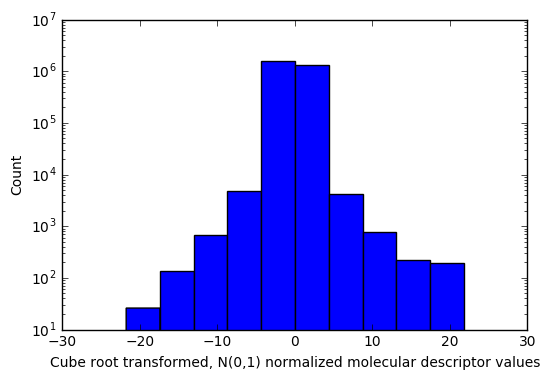

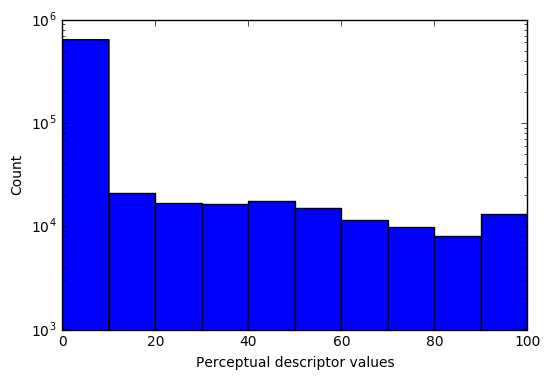

In [16]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_all.drop(['dilution','mean_dilution'],1).values.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_tl.fillna(Y_tl.median(),axis=0).values.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Perceptual descriptor values');

### Fitting and Generating Submission Files

In [17]:
n_estimators = 10 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
trans_params = params.get_trans_params(perceptual_data, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

In [18]:
# Fit training data (not counting leaderboard data). Ignoring warning that arises if too few trees are used.  
rfcs_leaderboard,score,rs = fit2.rfc_final(X_training,Y_training,Y_training_imputed,
                            max_features,min_samples_leaf,max_depth,use_et,use_mask,trans_weight,trans_params,
                            n_estimators=n_estimators)

No test data provided; score will indicate in-sample prediction quality
Fitting...
97.62% [------------------------------------------------- ]
Predicting...
Score: 15.224511; rs = 1.000,0.955,0.866,0.889,0.810,0.794
For subchallenge 2:
	Score = 15.22
	int_mean = 1.000
	int_std = 0.889
	ple_mean = 0.955
	ple_std = 0.810
	dec_mean = 0.866
	dec_std = 0.794


In [19]:
dream.make_prediction_files(rfcs_leaderboard,X_leaderboard,'leaderboard',2,Y_test=Y_leaderboard,write=False);

No Intensity information in the observed data.
No Intensity information in the observed data.
Score: nan; rs = nan,0.428,0.464,nan,-0.015,0.398


In [20]:
rfcs,score,rs = fit2.rfc_final(X_tl,Y_tl,Y_tl_imputed,
                            max_features,min_samples_leaf,max_depth,use_et,use_mask,trans_weight,trans_params,
                            n_estimators=n_estimators)

No test data provided; score will indicate in-sample prediction quality
Removing 69 CID/dilutions that are not in the observed data
Fitting...
97.62% [------------------------------------------------- ]
Predicting...
Score: 15.304530; rs = 1.000,0.963,0.864,0.889,0.848,0.798
For subchallenge 2:
	Score = 15.30
	int_mean = 1.000
	int_std = 0.889
	ple_mean = 0.963
	ple_std = 0.848
	dec_mean = 0.864
	dec_std = 0.798


In [21]:
dream.make_prediction_files(rfcs,X_testset,'testset',2,write=True);

Wrote to file with suffix "1491856823"
